In [173]:
#!pip install torch
#!pip install torchvision
#!pip install medmnist

In [174]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from torch.functional import F

import medmnist
from medmnist import INFO, Evaluator


import matplotlib.pyplot as plt


In [175]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We work on the 2D dataset with size 28x28

In [176]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [177]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [178]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\pedro\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    Lice

In [179]:
# visualization

train_dataset.montage(length=1)



c:\Users\pedro\anaconda3\lib\site-packages\medmnist\utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


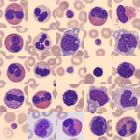

In [180]:

train_dataset.montage(length=5)

In [181]:
#Access a single image / label
image, label = train_dataset[2]  # image is a tensor , label is an  int
print("Shape da imagem:", image.shape)
print("Classe:", label)

# Convert to NumPy array
image_array = image.numpy()
print("Size:", image_array.shape )

#Access a subset of images
img = train_dataset[1][0].numpy   # image
lab = train_dataset[1][1]   # label
start_idx = 10
end_idx = 20  # exclusive
images_array = np.stack([train_dataset[i][0].numpy() for i in range(start_idx, end_idx)])
labels_array = np.array([train_dataset[i][1] for i in range(start_idx, end_idx)])

print("Size:", images_array.shape )
print(labels_array)




Shape da imagem: torch.Size([3, 28, 28])
Classe: [6]
Size: (3, 28, 28)
Size: (10, 3, 28, 28)
[[1]
 [1]
 [6]
 [7]
 [6]
 [3]
 [7]
 [2]
 [6]
 [1]]


## Flatten
Aqui vamos transformar os dados em tipo numpy e dar flatten aos inputs como precisam de ser vetores 1D e não imagens

In [ ]:
# Transformação dos datasets em inputs e outputs
x_train = train_dataset.imgs
y_train = train_dataset.labels
x_test = test_dataset.imgs
y_test = test_dataset.labels

# Converter para arrays NumPy (caso ainda sejam tensores)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


# Normalização para o cnn
x_train_cnn = x_train/255.0

x_test_cnn = x_test/255.0

# Flatten

x_train = x_train.reshape(x_train.shape[0], -1) 
x_test = x_test.reshape(x_test.shape[0], -1)

# Converter outra vez para tensors
x_train = torch.tensor(x_train).float()
x_train_cnn =  torch.tensor(x_train_cnn).float()

y_train = torch.tensor(y_train).long()

x_test = torch.tensor(x_test).float()
x_test_cnn =  torch.tensor(x_test_cnn).float()

y_test = torch.tensor(y_test).long()

num_inputs = x_train.shape[1]

### Normalização dos dados
 

In [183]:
scaler = StandardScaler()
x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)

x_test = torch.tensor(scaler.fit_transform(x_test), dtype=torch.float32)



In [184]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Implementação da DNN

In [185]:
class DNN(nn.Module): #mudar
    def __init__(self, input_size , hidden_sizes, num_classes = n_classes):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes))
        else:
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
            self.activations.append(nn.ReLU())        
        
            for i in range(len(hidden_sizes)-1):
                self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1])) # o chat sugeriu mudar os indices para i e o segundo i+1
                self.activations.append(nn.ReLU())

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))
    
        # camada de saida softmax
        #self.output_activation = nn.Softmax(dim=1)

    def forward(self, x):
        out = x
        for i in range(len(self.layers)): # All layers
            out = self.layers[i](out) # out = W out
            if i < len(self.activations):
                out = self.activations[i](out) # out = activation(out)

        #out = self.output_activation(out)

        return out



In [186]:
def fit(X_train, y_train, nn, criterion, optimizer, n_epochs, to_device=True, batch_size=BATCH_SIZE):
    #send everything to the device (ideally a GPU)
    
    y_train = y_train.squeeze()

    if to_device:
        nn = nn.to(device)
        X_train = X_train.to(device)
        y_train = y_train.to(device)

    # Train the network
    loss_values = []
    for epoch in range(n_epochs):
        accu_loss = 0
        for i in range(0, X_train.size(0), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = nn(X_batch)

            #print(outputs.shape)  # Deve ser [batch_size, n_classes]
            #print(y_batch.shape)  # Deve ser [batch_size]
            #print(y_batch.dtype)  # Deve ser torch.int64 (ou long)
            
            loss = criterion(outputs, y_batch)
            accu_loss += loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, accu_loss))
        loss_values.append(accu_loss)

    return loss_values, nn.to("cpu")

In [187]:
# Create the network, define criterion and optimizer
n_epochs = 10
n_layers = 1

# Determine the number of classes
hidden_layer_sizes = ((num_inputs + n_classes) // 2,)*n_layers
dnn = DNN(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=n_classes)



#this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class. 
#It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(dnn.parameters(), lr=0.1)
dnn_loss_values, dnn = fit(x_train, y_train, dnn, criterion, optimizer, n_epochs, batch_size=BATCH_SIZE, to_device=True)


Epoch [1/10], Loss: 72.7864
Epoch [2/10], Loss: 43.1666
Epoch [3/10], Loss: 31.9491
Epoch [4/10], Loss: 24.0238
Epoch [5/10], Loss: 17.8901
Epoch [6/10], Loss: 13.1958
Epoch [7/10], Loss: 9.6080
Epoch [8/10], Loss: 6.9880
Epoch [9/10], Loss: 5.1338
Epoch [10/10], Loss: 3.8386


In [188]:

def evaluate_network(net, X, y, to_device=True):
    # Set the model to evaluation mode
    net.eval()
    if to_device:
        X = X.to(device)
        net = net.to(device)

    # Run the model on the test data
    with torch.no_grad():
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)

    # Convert tensors to numpy arrays
    if to_device:
        predicted = predicted.to("cpu")
    predicted_np = predicted.numpy()
    test_target_np = y.numpy()

    # Compute confusion matrix and F1 score
    conf_mat = confusion_matrix(test_target_np, predicted_np)
    f1 = f1_score(test_target_np, predicted_np, average='weighted')

    print('Confusion Matrix:\n', conf_mat)
    print('F1 Score: ', f1)
    
print('Evaluating with the training data')
evaluate_network(dnn, x_train, y_train)

print('Evaluating with the test data')
evaluate_network(dnn, x_test, y_test)


Evaluating with the training data
Confusion Matrix:
 [[ 840    1    0    1   10    0    0    0]
 [   0 2181    0    0    0    0    0    0]
 [   1    0 1082    1    1    0    0    0]
 [   7    1    0 2001    1   14    2    0]
 [   0    0    0    0  849    0    0    0]
 [   9    0    0    2    3  979    0    0]
 [   0    0    0    0    0    0 2330    0]
 [   0    0    0    0    0    0    0 1643]]
F1 Score:  0.995487195237779
Evaluating with the test data
Confusion Matrix:
 [[174   3   0  39  11  15   2   0]
 [  1 605   0   6   2   0  10   0]
 [  3   1 267  14   7   6  11   2]
 [ 35  12   8 407  17  59  41   0]
 [  7   0  11  16 202   0   7   0]
 [  9   0   1  47   4 221   2   0]
 [  1  19   5  26   3   1 610   1]
 [  0   0   0   0   0   0   0 470]]
F1 Score:  0.8632848995047643


### CNN

In [189]:
# CNN


class CNN(nn.Module):
    def __init__(self, input_channels=3, num_classes = n_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding = 1)
        
        #8x8x8=512 is the dimension of the tensor after the last convolution. 
        #It consists of 8 filters of size 8x8 (due to pooling)
        # 8 hidden layers de fotos 7x7 (começam 28x28 -> 14x14 -> 7x7  por causa do max pooling)

        self.fc1 = nn.Linear(7*7*8, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x =  F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        x = x.view(-1, self.fc1.in_features)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [190]:
n_epochs = 50
cnn = CNN(3)




#this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class. 
#It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn.parameters(), lr=0.1)
dnn_loss_values, cnn = fit(x_train_cnn, y_train, cnn, criterion, optimizer, n_epochs, batch_size=BATCH_SIZE, to_device=True)

plt.plot(dnn_loss_values, label='DNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[128, 28, 28, 3] to have 3 channels, but got 28 channels instead